# Example 2: Fault correlation through time steps of 2-D numerical model
This example describes how to correlate faults extracted at different time steps.

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-wfextfvi
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-wfextfvi
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-iv2v_xhm/cv-algorithms_584db38458ff404c805ac38600f05836
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-iv2v_xhm/cv-algorithms_584db38458ff404c805ac38600f05836


and get the tutorials:

In [2]:
!git clone https://github.com/thilowrona/fatbox_tutorials

fatal: destination path 'fatbox_tutorials' already exists and is not an empty directory.


Now we can load the python packages:

In [36]:
import math
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import numpy as np
from ipywidgets import Layout, interactive, widgets
from tqdm import tqdm

from fatbox.metrics import total_length, get_fault, get_fault_labels
from fatbox.plots import plot_components, plot_attribute, plot_faults

## Load and visualize networks

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [7]:
Gs = []
for n in range(3,50):
  Gs.append(pickle.load(open('/content/fatbox_tutorials/Numerical_models/3-time_stepping/graphs/g_'+ str(n) + '.p', 'rb')))

Now we can visualize and compare the faults extracted through time:

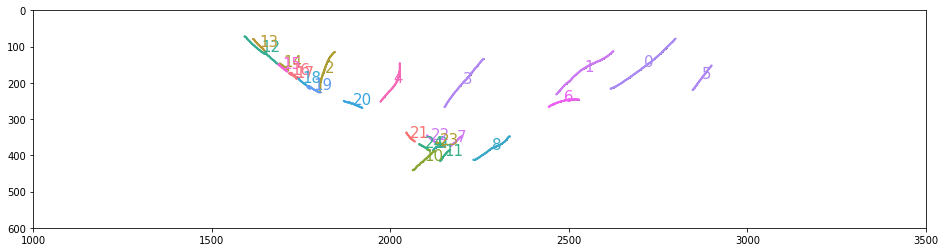

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…

In [76]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_components(Gs[time], node_size=1, ax=ax)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot


The faults have different labels in every time steps. That's a result of the extraction, where arbitrary labels are assigned to the faults. To track faults through time, we want these labels to be consistent between time steps. So let's look at two consecutive time steps:

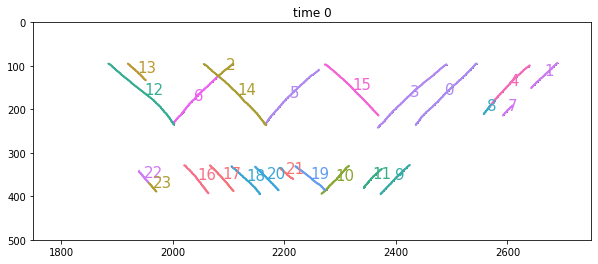

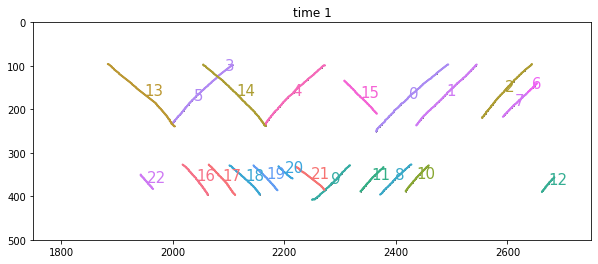

In [83]:
G_0 = Gs[0]
G_1 = Gs[1]

fig, ax = plt.subplots(figsize=(10,4))
plot_components(G_0, node_size=1, ax=ax)
ax.set_title('time 0')
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
plot_components(G_1, node_size=1, ax=ax)
ax.set_title('time 1')
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()

## Correlate two time steps

We can already see that the green fault 12 at time 0 is probably the same as the red fault 13 at time 1. So in order to match them, we will compare all faults between two time steps and re-label them.

But first we will introduce a new label. We typically extract faults as components of the graph (i.e. nodes connected to one another). But geological faults can consist of multiple of such components, such as faults 22 and 23 at time 0 - they probably belong to one fault. So let's introduce this new label called 'fault' based on the components:

In [12]:
for node in G_0:
    G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

for node in G_1:
    G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

print(G_0.nodes[0])

{'pos': (2544, 95), 'component': 0, 'polarity': 0, 'edges': 2, 'fault': 0}


Now it's getting interesting. To correlate faults across time steps, we want to check how similar each fault from time step 0 is to each fault from time step 1. This will allow us to correlate fault even if they merg or split up between time steps. To do this, we first calculate the similarity and then correlate faults if their similarity is above a certain threshold:

In [13]:
def get_nodes(G):
    labels = get_fault_labels(G)
    point_set=[]
    for label in labels:            
        G_fault = get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set


def compute_similarity(set_A, set_B):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      return np.mean(np.min(distances, axis=1))


def correlation_slow(G_0, G_1, R):
    # A function which labels the faults in G_1 according to G_0 using the 
    # minimum radius R
    
    
    # Get labels and nodes
    fault_labels_0 = get_fault_labels(G_0)
    fault_labels_1 = get_fault_labels(G_1)
    
    nodes_0 = get_nodes(G_0)
    nodes_1 = get_nodes(G_1) 


    # Compute similarities    
    smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
    smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))    
    
    
    for n in tqdm(range(len(fault_labels_0)), desc='   Compute similarities'):
        for m in range(len(fault_labels_1)):
            smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
            smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])
            
            
    # Determine correlations
    correlations = set()
    for n in tqdm(range(len(fault_labels_0)), desc='   Find correlations'):
        for m in range(len(fault_labels_1)):
            if smf[n,m] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))
            if smb[m,n] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))                 

    return correlations, smf, smb

In [62]:
R = 5
correlations, smf, smb = correlation_slow(G_0, G_1, R=R)

   Find correlations: 100%|██████████| 24/24 [00:00<00:00, 20430.95it/s]


So let's look at the similarities between the faults:

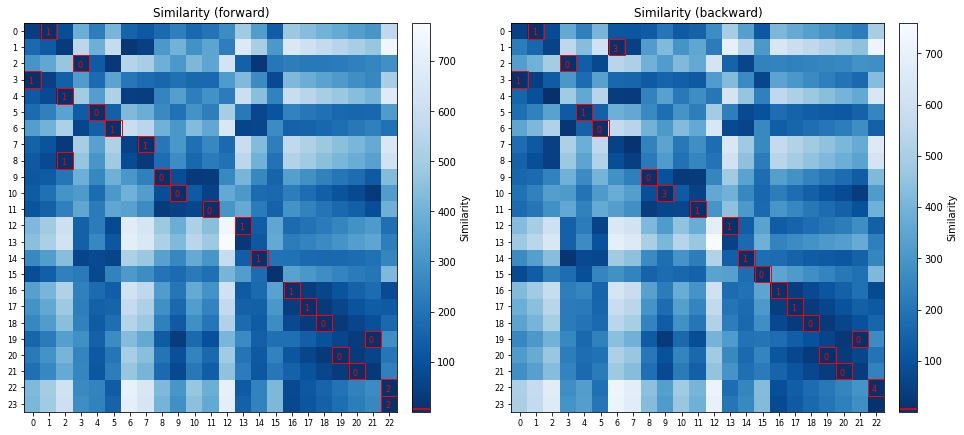

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

axs[0].set_title('Similarity (forward)')
im_0 = axs[0].imshow(smf, cmap='Blues_r')
axs[0].set_yticks(range(smf.shape[0]))
axs[0].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[0].set_xticks(range(smf.shape[1]))
axs[0].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_0, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smf.shape[0]):
    for y in range(smf.shape[1]):
        if smf[x,y] < R:
            axs[0].text(y-0.25,x+0.25, int(smf[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((y-0.5, x-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[0].add_patch(rect)
        else:
            pass


axs[1].set_title('Similarity (backward)')
im_1 = axs[1].imshow(np.transpose(smb), cmap='Blues_r')
axs[1].set_yticks(range(smf.shape[0]))
axs[1].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[1].set_xticks(range(smf.shape[1]))
axs[1].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_1, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smb.shape[0]):
    for y in range(smb.shape[1]):
        if smb[x,y] < R:
            axs[1].text(x-0.25,y+0.25, int(smb[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[1].add_patch(rect)
        else:
            pass

plt.show()

Note that we get two similarity matrices, because we compare faults from both time step forward and backward in time.

Most importantly, we can check whether most faults are correlated and then adjust the value R if necessary. R is a measure for the minimal distance between faults to be correlated, so higher values loosen the correlation and lower values tighten it.

Moreover, we can check the correlation directly:

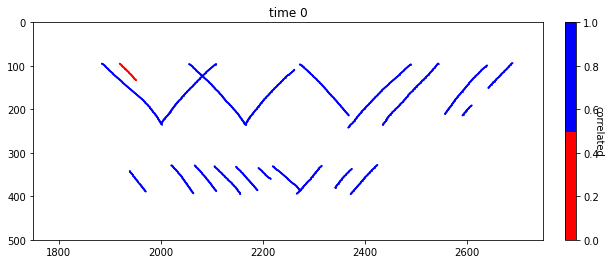

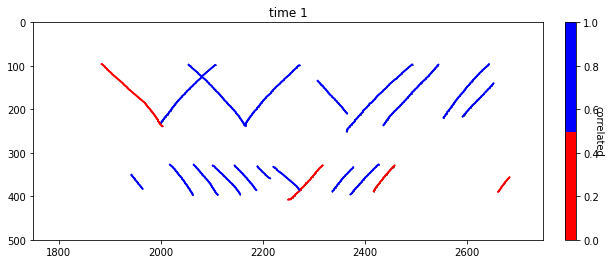

In [86]:
import matplotlib.colors
cmap_rb = matplotlib.colors.ListedColormap(['red', 'blue'])

for node in G_0:
    if G_0.nodes[node]['fault'] in [corr[0] for corr in correlations]:
        G_0.nodes[node]['correlated'] = 1
    else:
        G_0.nodes[node]['correlated'] = 0


for node in G_1:
    if G_1.nodes[node]['fault'] in [corr[1] for corr in correlations]:
        G_1.nodes[node]['correlated'] = 1
    else:
        G_1.nodes[node]['correlated'] = 0



fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title('time 0')
plot_attribute(G_0, 'correlated', cmap=cmap_rb, vmin=0, vmax=1, ax=ax)
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()


fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title('time 1')
plot_attribute(G_1, 'correlated', cmap=cmap_rb, vmin=0, vmax=1, ax=ax)
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()

LOoks good, so let's relabel the faults in time step 1 to match time step 0:

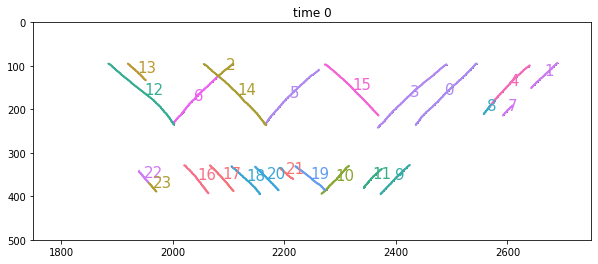

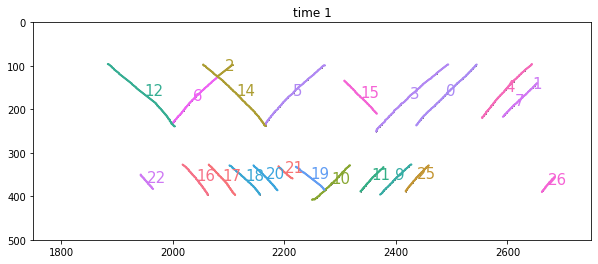

In [84]:
def relabel(G_1, correlations):
        
    # A function, which relabels G_1 using the correlations
    for node in G_1:
        G_1.nodes[node]['correlated']=0
    
    lengths = [total_length(get_fault(G_0, correlation[0]), calculate=True) for correlation in correlations]
    lengths, correlations = zip(*sorted(zip(lengths, correlations)))
    
    
    for node in G_1:
        for correlation in correlations:
            if G_1.nodes[node]['component'] == correlation[1]:
                G_1.nodes[node]['fault'] = correlation[0]
                G_1.nodes[node]['correlated'] = 1
    
    max_comp = max(get_fault_labels(G_1))
    
    G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==0])  
    for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))): 
        for n in cc:
            G_1.nodes[n]['fault'] = label+max_comp+1
        
    return G_1


G_1 = relabel(G_1, correlations)

fig, ax = plt.subplots(figsize=(10,4))
plot_faults(G_0, node_size=1, ax=ax)
ax.set_title('time 0')
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
plot_faults(G_1, node_size=1, ax=ax)
ax.set_title('time 1')
ax.set_xlim([1750, 2750])
ax.set_ylim([500, 0])
plt.show()

Awesome! It worked! You can see that faults in the same location have the same label.